# Generate state vector netcdf file from shape file

Use this notebook to create an IMI state vector file for an irregular region of interest using a shape file for the region.

Example here is for the Permian Basin.

(You might notice that the resulting state vector is different than the one used in Varon et al. (2022) for the Permian. That's because Varon et al. used some manual steps to define their state vector from the Permian shape file.)

In [1]:
import xarray as xr 
import numpy as np
import regionmask
import xesmf as xe
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
from sklearn.cluster import KMeans
import colorcet as cc
import matplotlib.pyplot as plt
import yaml
import warnings; warnings.filterwarnings(action='ignore')
%matplotlib inline

# Setup

In [2]:
# Read config file
config = yaml.load(open("/home/ubuntu/setup_CH4/config.yml"), Loader=yaml.FullLoader)

In [3]:
# Set longitude and latitude bounds for inversion domain
#lon_min = config['LonMinCustomStateVector']
#lon_max = config['LonMaxCustomStateVector']
#lat_min = config['LatMinCustomStateVector']
#lat_max = config['LatMaxCustomStateVector']

lon_min = -111
lon_max = -95
lat_min = 24
lat_max = 39

# Create lat/lon grid
dlon = 0.1
dlat = 0.1
lon = np.arange(lon_min, lon_max+dlon, dlon)
lat = np.arange(lat_min, lat_max+dlat, dlat)

# Inversion spatial resolution
if config['Res'] == '0.25x0.3125':
    lat_res = 0.25
    lon_res = 0.3125
elif config['Res'] == '0.5x0.625':
    lat_res = 0.5
    lon_res = 0.625

### Create region of interest mask from shape file

In [4]:
# Open shape file with geopandas
shape = gpd.read_file(config['ShapeFile'])
shape

,geometry
0,"POLYGON ((-100.54152 33.84438, -100.50482 33.6..."


In [5]:
# Make mask from shape file
mask = regionmask.mask_geopandas(shape, lon, lat) + 1 # Add 1 so the mask values are 1 instead of 0
mask

<xarray.DataArray 'region' (lat: 151, lon: 161)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 24.0 24.1 24.2 24.3 24.4 ... 38.6 38.7 38.8 38.9 39.0
  * lon      (lon) float64 -111.0 -110.9 -110.8 -110.7 ... -95.2 -95.1 -95.0

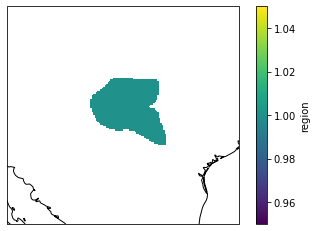

In [6]:
# View the mask in the inversion domain
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
)
ax.coastlines();

### Regrid mask to 0.25 x 0.3125 or 0.5x0.625 grid

In [7]:
# Need to regrid to the grid HEMCO expects
reference_lat_grid = np.arange(-90 , 90+lat_res , lat_res)
reference_lon_grid = np.arange(-180, 180+lon_res, lon_res)

# Find closest reference coordinates to selected lat/lon bounds
lat_min = reference_lat_grid[np.abs(reference_lat_grid - lat_min).argmin()]
lon_min = reference_lon_grid[np.abs(reference_lon_grid - lon_min).argmin()]
lat_max = reference_lat_grid[np.abs(reference_lat_grid - lat_max).argmin()]
lon_max = reference_lon_grid[np.abs(reference_lon_grid - lon_max).argmin()]

# Create an xESMF regridder object to resample the mask on the grid HEMCO expects
new_lat_grid = np.arange(lat_min, lat_max+lat_res, lat_res)
new_lon_grid = np.arange(lon_min, lon_max+lon_res, lon_res)
ds_out = xr.Dataset({'lat': (['lat'], new_lat_grid),
                     'lon': (['lon'], new_lon_grid),
                    }
                   )
#ds_out = ds_out.rename({'longitude': 'lon', 'latitude': 'lat'})

regridder = xe.Regridder(mask, ds_out, 'nearest_s2d')
regridder

xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_151x161_61x52.nc 
Reuse pre-computed weights? False 
Input grid shape:           (151, 161) 
Output grid shape:          (61, 52) 
Periodic in longitude?      False

In [8]:
# Regrid the mask
mask = regridder(mask)
mask

<xarray.DataArray (lat: 61, lon: 52)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -110.9 -110.6 -110.3 -110.0 ... -95.62 -95.31 -95.0
  * lat      (lat) float64 24.0 24.25 24.5 24.75 25.0 ... 38.25 38.5 38.75 39.0
Attributes:
    regrid_method:  nearest_s2d

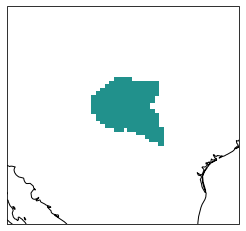

In [9]:
# View the regridded mask in the inversion domain
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ax.coastlines();

### Label the state vector elements

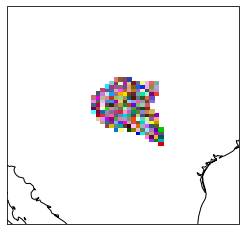

In [10]:
# Enumerate state vector elements
state_vector = mask.copy()
n_lat = len(new_lat_grid)
n_lon = len(new_lon_grid)
count = 1
for r in range(n_lat):
    for c in range(n_lon):
        if state_vector[r,c] == 1:
            state_vector[r,c] = count
            count += 1

# Plot
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
state_vector.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cc.cm.glasbey,
    add_colorbar=False,
)
ax.coastlines();

### Add buffer clusters

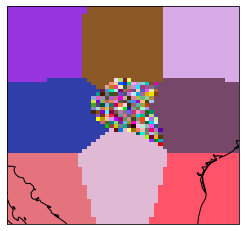

In [11]:
# Add buffer elements
buffer_elements = np.abs((mask > 0) - 1).values

# Get image coordinates of buffer elements
irows = np.arange(buffer_elements.shape[0])
icols = np.arange(buffer_elements.shape[1])
irows = np.transpose(np.tile(irows,(len(icols),1)))
icols = np.tile(icols,(len(irows),1)) * (buffer_elements > 0)

# Select image coordinates of buffer elements
irows_buffer = irows[buffer_elements > 0]
icols_buffer = icols[buffer_elements > 0]
coords = [[icols_buffer[j], irows_buffer[j]] for j in range(len(irows_buffer))]

# Kmeans based on image coordinates
X = np.array(coords)
kmeans = KMeans(n_clusters=config['nBufferClusters'], random_state=0).fit(X)

# Assign labels
for r in range(n_lat):
    for c in range(n_lon):
        if np.isnan(state_vector[r,c]):
            state_vector[r,c] = kmeans.predict([[c,r]])[0] + count

# Add units attribute
state_vector.attrs['units'] = 'none'
state_vector
            
# Plot
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
state_vector.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cc.cm.glasbey,
    add_colorbar=False,
)
ax.coastlines();

### Save the state vector to netcdf

In [12]:
# Create dataset
ds_state_vector = xr.Dataset(
                {
                    "state_vector": (["lat", "lon"], state_vector),
                },
                coords={
                    "lon": ("lon", new_lon_grid),
                    "lat": ("lat", new_lat_grid),
                },
                
                )

# Add attribute metadata
ds_state_vector.lat.attrs['units'] = 'degrees_north'
ds_state_vector.lat.attrs['long_name'] = 'Latitude'
ds_state_vector.lon.attrs['units'] = 'degrees_east'
ds_state_vector.lon.attrs['long_name'] = 'Longitude'
ds_state_vector.state_vector.attrs['units'] = 'none'
ds_state_vector

<xarray.Dataset>
Dimensions:       (lat: 61, lon: 52)
Coordinates:
  * lon           (lon) float64 -110.9 -110.6 -110.3 ... -95.62 -95.31 -95.0
  * lat           (lat) float64 24.0 24.25 24.5 24.75 ... 38.25 38.5 38.75 39.0
Data variables:
    state_vector  (lat, lon) float64 204.0 204.0 204.0 ... 200.0 200.0 200.0

State vector has 207 emission elements


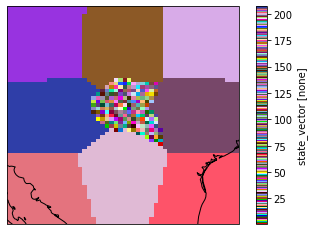

In [13]:
# Show final state vector and count elements for confirmation
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_state_vector.state_vector.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cc.cm.glasbey,
    add_colorbar=True,
)
ax.coastlines();

# Unique state vector elements
num_elements = len(np.unique(state_vector.values))
print('State vector has',num_elements,'emission elements')

In [14]:
# Save
save = False

if save:
    save_pth = ''
    ds_state_vector.to_netcdf(save_pth)

----